In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)


In [2]:
df2 = pd.read_csv('C:\\Users\\John\\Documents\\notGitHub\\trip_csv\\trippub.csv')
df2 = df2[df2.HH_CBSA != "XXXXX"]
df2['HH_CBSA'] = df2.HH_CBSA.astype(int)
df2 = df2[df2['HH_CBSA'] == 47900]

df2['TRPTRANS'] = df2.TRPTRANS.astype(int)
df2['local_rail'] = (df2.TRPTRANS==16)
df2['drove'] = (df2.TRPTRANS==3)|(df2.TRPTRANS==
                4)|(df2.TRPTRANS==5)|(df2.TRPTRANS==
                6)|(df2.TRPTRANS==18)
df2.TRACC_WLK.value_counts()


-1    5621
 1     314
 2      66
Name: TRACC_WLK, dtype: int64

In [3]:
public = df2.PUBTRANS.value_counts()
walk_to = df2.TRACC_WLK.value_counts()
walk_from = df2.TREGR_WLK.value_counts()
drove_to = df2.TREGR_POV.value_counts()
drove_from = df2.TRACC_POV.value_counts()


public_frac = public[1]/(public[1]+public[2])
walk_to_p = walk_to[1]/(walk_to[1]+walk_to[2])
walk_from_p = walk_from[1]/(walk_from[1]+walk_from[2])
drove_to_p = drove_to[1]/(drove_to[1]+drove_to[2])
drove_from_p = drove_from[1]/(drove_from[1]+drove_from[2])

print('Trips using public transit: ', "{0:.2f}%".format(public_frac*100))
print('Percent walking to transit: ', "{0:.2f}%".format(walk_to_p*100))
print('Percent walking from transit: ', "{0:.2f}%".format(walk_from_p*100))
print('Percent driving to transit: ', "{0:.2f}%".format(drove_to_p*100))
print('Percent driving from transit: ', "{0:.2f}%".format(drove_from_p*100))

Trips using public transit:  6.33%
Percent walking to transit:  82.63%
Percent walking from transit:  83.16%
Percent driving to transit:  6.58%
Percent driving from transit:  8.95%


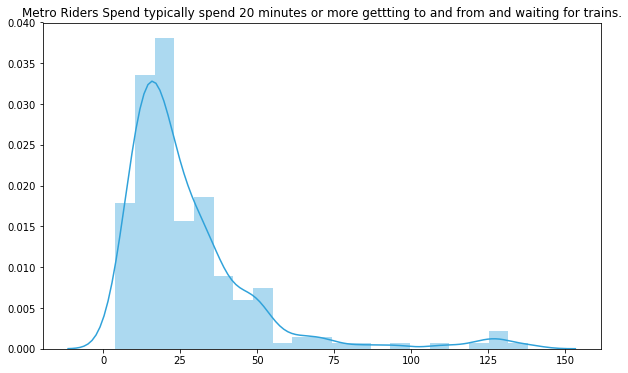

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df2[df2.local_rail].TRACCTM+df2[df2.local_rail].TREGRTM+df2[df2.local_rail].TRWAITTM)

ax.set_title('Metro Riders Spend typically spend 20 minutes or more gettting to and from and waiting for trains.');

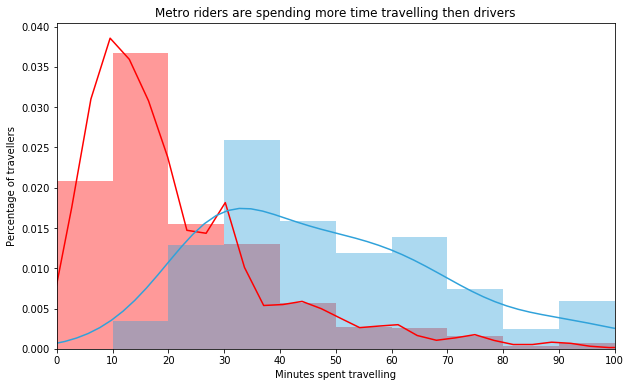

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

bins = [0,10,20,30,40,50,60,70,80,90,100]

sns.distplot(df2[df2.drove].TRVLCMIN,
             bins=bins, ax=ax, norm_hist=True,color="red")
sns.distplot(df2[df2.local_rail].TRVLCMIN,
             bins=bins, ax=ax, norm_hist=True)

ax.set_title('Metro riders are spending more time travelling then drivers')
ax.set_xlabel('Minutes spent travelling')
ax.set_ylabel('Percentage of travellers')
ax.set_xlim(0,100)
ax.set_xticks(bins);

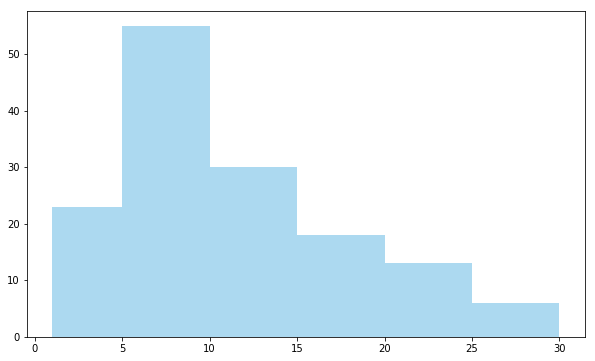

In [6]:
# I want to see if any member of the household ever walked to the metro in order to assess if it is in walking distance:
df2 = df2.replace({'TRACC_WLK':{2:0}})

df2[['TRACC_WLK', 'HOUSEID']].groupby('HOUSEID').max().TRACC_WLK.value_counts()

df2['walk_times'] = (df2.TRACCTM * df2.replace({'TRACC_WLK':{2:0, -1:0, -9:0}}).TRACC_WLK).dropna()

walk_times_max = df2[['walk_times', 'HOUSEID']].groupby('HOUSEID').max()

bins = [1,5,10,15,20,25,30]
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(walk_times_max, ax=ax, bins = bins, kde=False)

In [7]:
df2.replace({'TREGR_WLK':{2:0, -1:0, -9:0}}).TREGR_WLK.value_counts()

0    5685
1     316
Name: TREGR_WLK, dtype: int64

In [8]:
df2[['walk_times', 'HOUSEID']].groupby(['HOUSEID']).max().shape, df2.shape

((771, 1), (6001, 105))

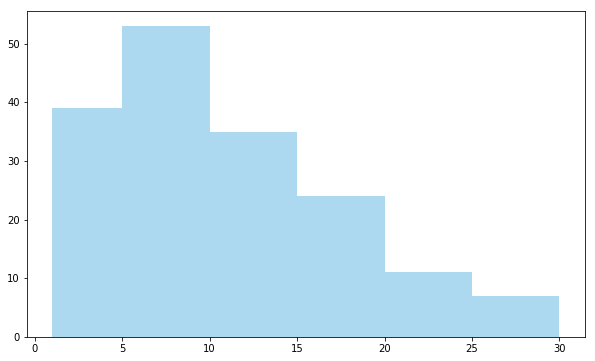

In [9]:
# repeating but from destination and using person id instead

df2 = df2.replace({'TREGR_WLK':{2:0}})

df2[['TREGR_WLK', 'HOUSEID', 'PERSONID']].groupby(['HOUSEID', 'PERSONID']).max().TREGR_WLK.value_counts()

df2['walk_times_after'] = (df2.TREGRTM * df2.replace({'TREGR_WLK':{2:0, -1:0, -9:0}}).TREGR_WLK)

walk_times_after_max = df2[['walk_times_after', 'HOUSEID', 'PERSONID']].groupby(['HOUSEID', 'PERSONID']).max()

bins = [1,5,10,15,20,25,30]
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(walk_times_after_max, ax=ax, bins = bins, kde=False)

In [10]:
walk_times_max.columns = ['max_walk_to']
walk_times_after_max.columns = ['max_walk_from']

In [11]:

df3 = df2.merge(walk_times_after_max.replace({'max_walk_from':{0:200}}).reset_index(), how='left').merge(
    walk_times_max.replace({'max_walk_to':{0:200}}).reset_index(), how='left')

In [12]:
df3[df3.drove].max_walk_from.describe()

count    4039.000000
mean      195.049765
std        30.356031
min         1.000000
25%       200.000000
50%       200.000000
75%       200.000000
max       200.000000
Name: max_walk_from, dtype: float64

In [13]:
df3['Within 10 minutes of transit'] = np.where(df3['max_walk_to']<10, 1, 0)
df3['Within 15 minutes of transit'] = np.where(df3['max_walk_to']<15, 1, 0)
df3['Within 30 minutes of transit'] = np.where(df3['max_walk_to']<30, 1, 0)
df3['Miles Traveled'] = pd.cut(df3.TRPMILES,4,labels=[1,2,3,4])
df3['Car Owner'] =  np.where(df3['HHVEHCNT']>0, 1, 0)
df3['Going to Work'] =  np.where(df3['TRIPPURP']=='HBW', 1, 0)

X = df3[['Miles Traveled', 'Within 15 minutes of transit', 'Car Owner', 'Going to Work']]
y = df3.local_rail

cv = StratifiedKFold(n_splits=5, shuffle=True)
dt = RandomForestClassifier(class_weight = 'balanced')
s = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)
s


array([0.78434638, 0.78583333, 0.79666667, 0.78833333, 0.79416667])

In [14]:

hyper_parameters = {
             'n_estimators':range(10,50,10),
             'min_samples_split':range(2, 14, 3),
             'max_depth':range(2, 14, 4)
}

sherwood = GridSearchCV(dt, hyper_parameters, cv=5, verbose=1, n_jobs=-1)

robin = sherwood.fit(X, y)

robin.best_params_, robin.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 233 out of 240 | elapsed:   12.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   12.8s finished


({'max_depth': 2, 'min_samples_split': 5, 'n_estimators': 20},
 0.8240293284452591)

In [15]:
strengths = pd.DataFrame([np.array(X.columns.tolist()).T,robin.best_estimator_.feature_importances_]).T
strengths.columns = ['Instrumental Variable', 'Importance']
strengths.sort_values('Importance', ascending=False)

,Instrumental Variable,Importance
3,Going to Work,0.467637
1,Within 15 minutes of transit,0.445039
2,Car Owner,0.0865589
0,Miles Traveled,0.000764491


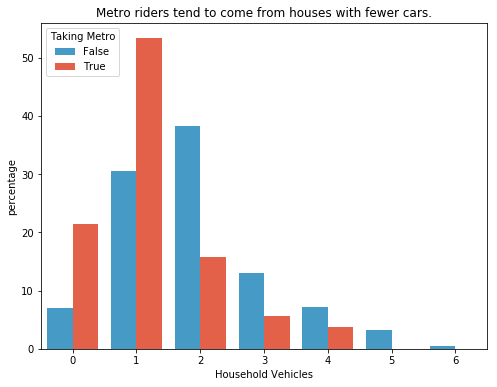

In [16]:
df3['Taking Metro'] = df3.local_rail
df3['Household Vehicles'] = df3.HHVEHCNT

fig, ax = plt.subplots(figsize=(8, 6))

vehicle_percentages = (df3.groupby(['Taking Metro'])['Household Vehicles']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Household Vehicles'))

ax = sns.barplot(x="Household Vehicles", y="percentage", hue="Taking Metro",
                    data=vehicle_percentages)
ax.format_ydata
ax.set_xlim(-0.5,6.5)
ax.set_title('Metro riders tend to come from houses with fewer cars.');

In [20]:
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import graphviz


# initialize the output file object
dot_data = StringIO() 

best = robin.best_estimator_.fit(X,y)


export_graphviz(best, out_file="mytree.dot", 
                    filled=True, rounded=True,
                    special_characters=True)
with open("mytree.dot") as f:
        dot_graph = f.read()
display(graphviz.Source(dot_graph))

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.